## Modules à importer

In [38]:
import re
import math
import glob
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import iminuit as im
import ipywidgets as ipw
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import matplotlib as mpl
import random
from snprop import age
from scipy import stats
from pymage import query
from astropy import units
from variaIa import tools as Iatools
from snprop import survey, tools
from matplotlib.colors import Normalize
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import Planck15 as Planck15
from scipy.interpolate import interp2d as spline
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
from variaIa import stretchevol
from variaIa import massevol
from importlib import reload

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=Iatools.cons, su=Iatools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
#smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'LOWZ': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nlowz = df_nc[df_nc['survey'] != 'low-z']
df_full_data = df_full[~df_full['survey'].isin(['SNF', 'HST'])]

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

## Basic plots

### Choose simu

In [3]:
sim_path = glob.glob("../../../Data/sims/NN_COMBINE_*FULL/*/output/OUTPUT_BBCFIT*")
sc = ipw.Dropdown(options=sim_path,
                  description='Sim choice',
                  value=sim_path[0])

def set_fitprop(path):
    global fitprop_data
    if len(glob.glob(path + '/fitprop_data')) == 0:
        fitprop_data = []
    else:
        with open(path + '/fitprop_data', 'rb') as f:
            fitprop_data = pickle.load(f)

int_set_fitprop = ipw.interactive(set_fitprop, path=sc)
display(int_set_fitprop)

interactive(children=(Dropdown(description='Sim choice', options=('../../../Data/sims/NN_COMBINE_FULL/ALL_BIAS…

### Load selected

In [67]:
for fd in sim_path[:9]:
    fitres_list = glob.glob(fd + '/FIT*.FITRES')
    fitres = tools.Checker.read(fitres_list[-1])
    print(fd, 'len fitres =', len(fitres))

../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_SK_SK/output/OUTPUT_BBCFIT len fitres = 10614
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_NN_BP/output/OUTPUT_BBCFIT len fitres = 10585
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_BP_BP/output/OUTPUT_BBCFIT len fitres = 9837
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_BP_SK/output/OUTPUT_BBCFIT len fitres = 9674
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_SK_NN/output/OUTPUT_BBCFIT len fitres = 10417
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_NN_SK/output/OUTPUT_BBCFIT len fitres = 10546
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT len fitres = 10817
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_SK_BP/output/OUTPUT_BBCFIT len fitres = 10410
../../../Data/sims/NN_COMBINE_FULL/ALL_BIASCOR_BP_NN/output/OUTPUT_BBCFIT len fitres = 9727


In [20]:
fitres_list = glob.glob(sc.value + '/FIT*.FITRES')
fitres_list

['../../../Data/sims/NN_COMBINE_VFULL/ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT/FITOPT000_MUOPT002.FITRES',
 '../../../Data/sims/NN_COMBINE_VFULL/ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT/FITOPT000_MUOPT001.FITRES',
 '../../../Data/sims/NN_COMBINE_VFULL/ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT/FITOPT000_MUOPT000.FITRES']

In [21]:
fitres = tools.Checker.read(fitres_list[-1])

### Sample sims to data

In [22]:
fitres_data = tools.Checker.sample_sims(fitres,
                                        #df_c[df_c['survey'].isin(surveys[2:-1])])
                                        df_full_data)

#### Just to check

In [23]:
surveys_size = {survey: len(df_full[df_full['survey'] == survey])
                for survey in surveys[1:-1]}

fitres_size = {survey: len(fitres[fitres['IDSURVEY'].isin(idsurvey)])
                 for survey, idsurvey in zip(surveys[1:-1],
                                             [[5, 64, 65, 66], [1], [15], [4]])}

fitres_data_size = {survey: len(fitres_data[fitres_data['IDSURVEY'].isin(idsurvey)])
                     for survey, idsurvey in zip(surveys[1:-1],
                                             [[5, 64, 65, 66], [1], [15], [4]])}

In [24]:
print('surveys_size =\t\t', surveys_size)
print('fitres_size =\t\t', fitres_size)
print('fitres_data_size =\t', fitres_data_size)

print('low-z ratio in data =', surveys_size['LOWZ']/surveys_size['LOWZ'])
print(' SDSS ratio in data =', surveys_size['SDSS']/surveys_size['LOWZ'])
print('  PS1 ratio in data =', surveys_size['PS1']/surveys_size['LOWZ'])
print(' SNLS ratio in data =', surveys_size['SNLS']/surveys_size['LOWZ'])

print('low-z ratio in uncut sims =', fitres_size['LOWZ']/fitres_size['LOWZ'])
print(' SDSS ratio in uncut sims =', fitres_size['SDSS']/fitres_size['LOWZ'])
print('  PS1 ratio in uncut sims =', fitres_size['PS1']/fitres_size['LOWZ'])
print(' SNLS ratio in uncut sims =', fitres_size['SNLS']/fitres_size['LOWZ'])

print('low-z ratio in cut sims =', fitres_data_size['LOWZ']/fitres_data_size['LOWZ'])
print(' SDSS ratio in cut sims =', fitres_data_size['SDSS']/fitres_data_size['LOWZ'])
print('  PS1 ratio in cut sims =', fitres_data_size['PS1']/fitres_data_size['LOWZ'])
print(' SNLS ratio in cut sims =', fitres_data_size['SNLS']/fitres_data_size['LOWZ'])

surveys_size =		 {'LOWZ': 172, 'SDSS': 335, 'PS1': 279, 'SNLS': 236}
fitres_size =		 {'LOWZ': 25337, 'SDSS': 33739, 'PS1': 27983, 'SNLS': 23035}
fitres_data_size =	 {'LOWZ': 16788, 'SDSS': 32697, 'PS1': 27231, 'SNLS': 23034}
low-z ratio in data = 1.0
 SDSS ratio in data = 1.947674418604651
  PS1 ratio in data = 1.622093023255814
 SNLS ratio in data = 1.372093023255814
low-z ratio in uncut sims = 1.0
 SDSS ratio in uncut sims = 1.3316098985673126
  PS1 ratio in uncut sims = 1.1044322532265067
 SNLS ratio in uncut sims = 0.909144729052374
low-z ratio in cut sims = 1.0
 SDSS ratio in cut sims = 1.9476411722659042
  PS1 ratio in cut sims = 1.6220514653323803
 SNLS ratio in cut sims = 1.3720514653323803


### Save cut and sampled data

In [25]:
pickle.dump(fitres_data, open(sc.value + '/fitres_data', 'wb'))

In [4]:
with open(sc.value + '/fitres_data', 'rb') as f:
    fitres_data = pickle.load(f)

### Now plot!

In [73]:
num_list = tools.Checker.get_numbers(sc.value)
np.asarray(num_list)

array([['000', '000'],
       ['000', '001'],
       ['000', '002']], dtype='<U3')

In [6]:
checkit = tools.Checker(sc.value,
                        df_full_data)
                        #df_c[df_c['survey'].isin(surveys[2:-1])])

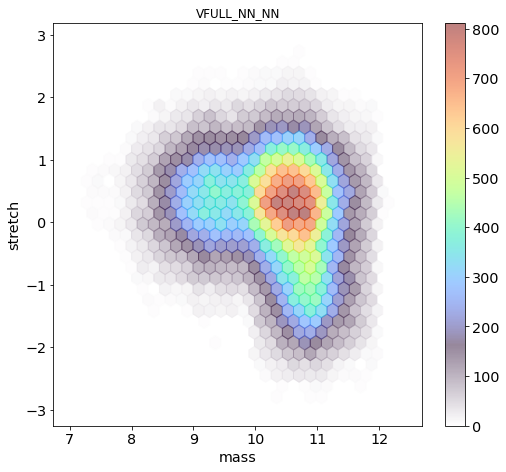

In [8]:
fig = plt.figure(figsize=[8,7])
ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])

checkit.show_scatter('mass', 'stretch', ax=ax, fc_data='k', alpha_data=0.0, mk_data='v')

ax.set_title(checkit.name)

fig.savefig(f'../../../Images/pdf/{checkit.name}_MS_scatter.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{checkit.name}_MS_scatter.png', bbox_inches='tight', dpi=600)

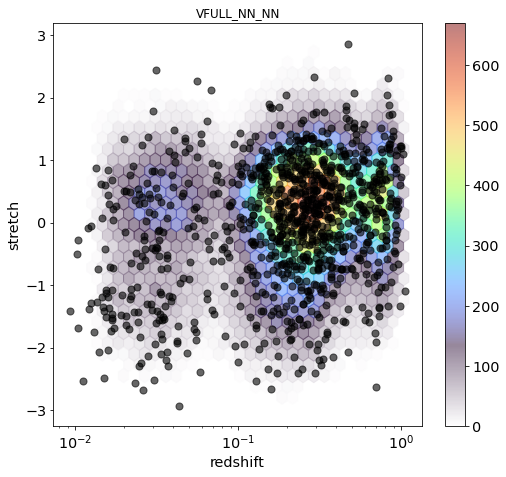

In [9]:
fig = plt.figure(figsize=[8,7])
ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])

checkit.show_scatter('redshift', 'stretch', ax=ax, fc_data='k', alpha_data=0.6, xsimscale='log')
ax.set_title(checkit.name)

fig.savefig(f'../../../Images/pdf/{checkit.name}_RS_scatter.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{checkit.name}_RS_scatter.png', bbox_inches='tight', dpi=600)

In [28]:
checkit.set_kernel('mass', 'stretch', True)
checkit.set_kernel('redshift', 'stretch', True)

<Axes:xlabel='redshift', ylabel='stretch'>

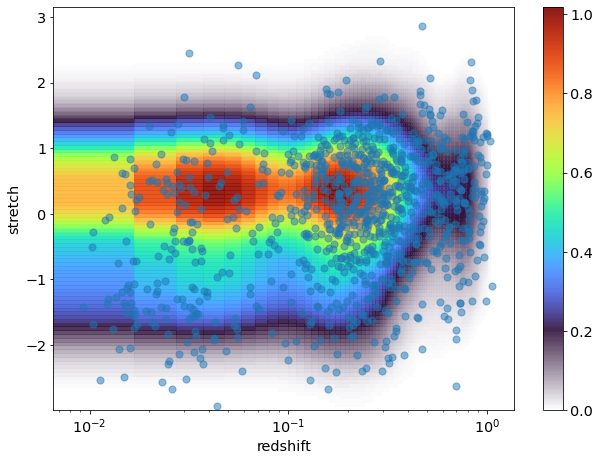

In [31]:
fig = plt.figure(figsize=[10, 7])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

#ax = checkit.show_kernel(kernel=kernel,
#                         abs_name='redshift', ord_name='stretch',
#                         aspect=.8, alpha_kernel=.50)

checkit.show_kernel('redshift_stretch', ax=ax,
                    alpha_kernel=.90)
                    #aspect=.4, alpha_kernel=.90)

ax.set_xscale('log')

checkit.show_scatter('redshift', 'stretch', ax=ax,
                     gsize=40,
                     #xsimscale='log', #cmap='inferno',
                     alpha_sims=0.0, show_cb=False, alpha_data=0.5)

In [122]:
checkit.fit('mass_stretch')
checkit.fit('redshift_stretch')

261.1805661345701

In [123]:
checkit.kernels

{'mass_stretch': <scipy.stats.kde.gaussian_kde at 0x7f96477a6650>,
 'redshift_stretch': <scipy.stats.kde.gaussian_kde at 0x7f96494e3ed0>}

In [124]:
checkit.fits

{'mass_stretch': 31.635585952691407, 'redshift_stretch': 261.1805661345701}

In [125]:
pickle.dump(checkit, open(sc.value + '/checkit', 'wb'))

In [134]:
with open(sc.value + '/checkit', 'rb') as f:
    checkit = pickle.load(f)

In [135]:
checkit.wfit

,w,wsig_marg,OM,OMsig_marg,chi2,Ndof,sigint,wran,OMran,label,ABORT_IF_ZERO,CPU_MINUTES,BLIND
1,-1.0105,0.0548,0.3106,0.0100,13.6,8,0.012,0,0,none,8 # same as Ndof,0.02,0


## Plot $w$, $\gamma$ values

In [42]:
FoS = ipw.Dropdown(options=['FULL', 'SSIZE', 'VFULL', 'VSIZE'],
                   description='Sim choice',
                   value='VSIZE')
MUO = ipw.Dropdown(options=[0, 1, 2],
                   description='MUOPTS choice',
                   value=0)
par = ipw.Dropdown(options=['alpha', 'beta', 'gamma'],
                   description='Param choice',
                   value='gamma')
display(FoS, MUO, par)

Dropdown(description='Sim choice', index=3, options=('FULL', 'SSIZE', 'VFULL', 'VSIZE'), value='VSIZE')

Dropdown(description='MUOPTS choice', options=(0, 1, 2), value=0)

Dropdown(description='Param choice', index=2, options=('alpha', 'beta', 'gamma'), value='gamma')

### $\gamma$

In [59]:
order = ['SK', 'NN', 'NR']
gab_df = {name: dict() for name in order}
data_show = {name: dict() for name in order}
erro_show = {name: dict() for name in order}
for i in order:
    for k in order:
        fd = f'../../../Data/sims/NN_COMBINE_{FoS.value}/' + \
             f'ALL_BIASCOR_{i}_{k}/output/'
        strs, inds = tools.Checker.get_numbers(fd, False)
        gab_df[i][k] = pd.concat([tools.Checker.read(fd +
                                                     f'OUTPUT_BBCFIT-{strs[n]}/' +
                                                     f'FITOPT000_MUOPT00{MUO.value}.FITRES',
                                                  True, inds[n])
                                 for n in range(len(inds))])
        data_show[i][k] = np.mean(gab_df[i][k][par.value])
        erro_show[i][k] = np.std(gab_df[i][k][par.value])/\
                          np.sqrt(len(gab_df[i][k][par.value]))
data_show = pd.DataFrame(data_show)

### $w$

In [22]:
if 'V' in FoS.value:
    # order = ['SK', 'BP', 'NN', 'NR']
    order = ['SK', 'NN', 'NR']
else:
    order = ['SK', 'BP', 'NN']
data_show = {name: dict() for name in order}
erro_show = {name: dict() for name in order}
for i in order:
    for k in order:
        wall = tools.Checker.read(f'../../../Data/sims/NN_COMBINE_{FoS.value}/' +
                                  f'ALL_BIASCOR_{i}_{k}/output/BBC_SUMMARY_wfit.FITRES')
        walla = wall[wall['MUOPT'] == MUO.value]
        data_show[i][k] = float(np.mean(walla.w))
        if 'FULL' in FoS.value:
            erro_show[i][k] = walla.wsig.values[0]
        else:
            erro_show[i][k] = np.std(walla.w)/np.sqrt(len(walla))
data_show = pd.DataFrame(data_show)

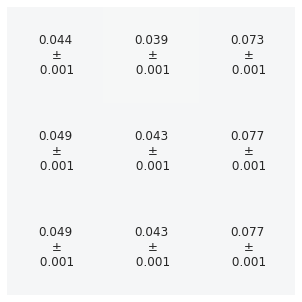

In [60]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

cbarlb = {'label': r'$w$ values',
          'fraction':0.05}#,
          #'labelsize': 'x-large'} #'aspect':50,
    
akws = {'fontsize': 'large'}

if 'V' in FoS.value:
    # xticklabels=['SK', 'BP', 'NN', 'NR']
    # yticklabels=['SK', 'BP', 'NN', 'NR']
    # xticklabels=['SK', 'NN', 'NR']
    # yticklabels=['SK', 'NN', 'NR']
    xticklabels=[]
    yticklabels=[]
else:
    # xticklabels=['SK', 'BP', 'NN']
    # yticklabels=['SK', 'BP', 'NN']
    xticklabels=[]
    yticklabels=[]
    
labels = [[f'{data_show[k][i]:.3f}\n ±\n {erro_show[k][i]:.3f}'
           for k in order]
          for i in order]
labels_z = [[f'{data_show[k][i]+1:.4f}\n ±\n {erro_show[k][i]:.4f}'
             for k in order]
            for i in order]

center = -1
cmap = mpl.cm.get_cmap('RdBu')
# data_show_diverr = (data_show+1)/0.0026
data_show_diverr = (data_show+1)/0.0026

sn.heatmap(data_show, ax=ax,
           annot=labels, annot_kws=akws, fmt='',
           cmap=cmap,# center=center,
           # vmin=-5, vmax=5,
           vmin=-5, vmax=5,
           cbar=False, #cbar_kws=cbarlb,
           xticklabels=xticklabels,
           yticklabels=yticklabels)

im = ax.collections[0]
rgba_values = im.cmap(im.norm(im.get_array()))

ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

ax.tick_params(labelsize='x-large')

#ax.set_title(FoS.value + '--' + str(MUO.value))

fig.savefig(f'../../../Images/pdf/gfit_covmat_raw-nBP_{FoS.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/gfit_covmat_raw-nBP_{FoS.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

#### Histograms

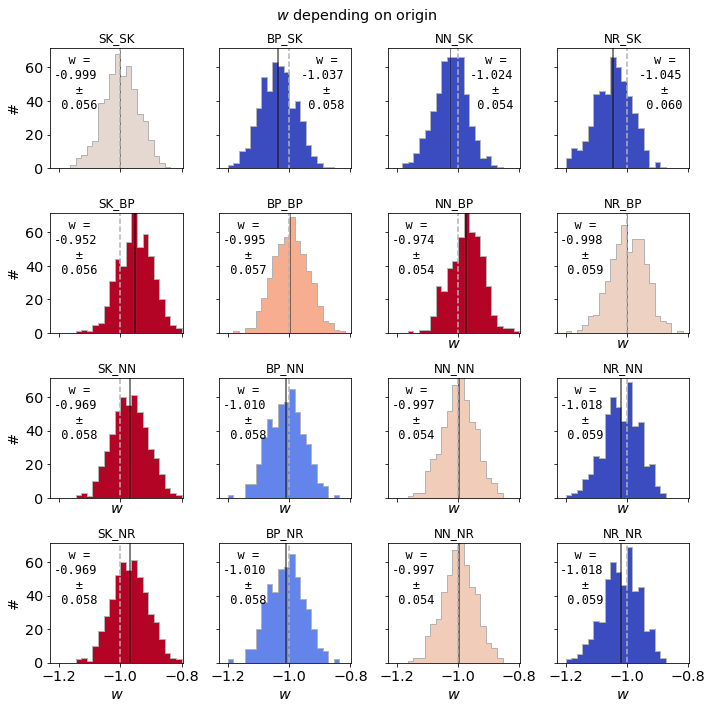

In [83]:
order = ['SK', 'BP', 'NN', 'NR']

n = -1
wmin = []
wmax = []

fig, ax = plt.subplots(4, 4, figsize=[10, 10], sharex=True, sharey=True)
for i,s in enumerate(order):
    for k,z in enumerate(order):
        n += 1
        wlist = tools.Checker.read(f'../../../Data/sims/NN_COMBINE_{FoS.value}/' +
                                  f'ALL_BIASCOR_{z}_{s}/output/BBC_SUMMARY_wfit.FITRES')
        wlist = wlist[wlist['MUOPT'] == 0]
        wmin.append(np.min(wlist.w))
        wmax.append(np.max(wlist.w))
        
        ax[i][k].hist(wlist.w,
                      range=(-1.2, -0.8), bins=22,
                      histtype='stepfilled',
                      color=rgba_values[n],
                      ec='0.7')
        ylim = ax[i][k].get_ylim()
        
        # ax[i][k].vline(np.mean(wlist.w), color='0.7', lw=0.5)
        werr = (np.std(wlist.w)/np.sqrt(500)) 
        ax[i][k].vspan(np.mean(wlist.w)+werr,
                       np.mean(wlist.w)-werr,
                       facecolor='k', edgecolor='w',
                       lw=0.1, alpha=.5)
        ax[i][k].vline(-1.0, ls='--', c='0.7')
        
        ax[i][k].set_ylim(ylim)
        
        mono = {'family' : 'monospace'}
        if 1 <= n <= 3:
            ax[i][k].text(0.95, 0.95,
                          f'w = \n{np.mean(wlist.w):.3f}\n±  \n {np.std(wlist.w):.3f}',
                          fontsize='large',
                          ha='right', va='top',
                          transform=ax[i][k].transAxes,
                          fontdict=mono)
        else:
            ax[i][k].text(0.025, 0.95,
                          f'  w =\n{np.mean(wlist.w):.3f}\n   ± \n {np.std(wlist.w):.3f}',
                          fontsize='large',
                          ha='left', va='top',
                          transform=ax[i][k].transAxes,
                          fontdict=mono)
        
        # ax[i][k].set_facecolor('0.9')
        
        ax[i][k].tick_params(labelsize='x-large')
        if n < 6:
            pass
        else:
            ax[i][k].set_xlabel(r'$w$', fontsize='x-large')
        if k > 0:
            pass
        else:
            ax[i][k].set_ylabel('#', fontsize='x-large')
        ax[i][k].set_title(f'{z}_{s}')

wmin = 1.01*np.min(wmin)
wmax = 0.99*np.max(wmax)

for i in range(3):
    for k in range(3):
        ax[i][k].set_xlim(wmin, wmax)
    
fig.suptitle(r'$w$ depending on origin', fontsize='x-large')

fig.tight_layout()

fig.savefig(f'../../../Images/pdf/wfit_hists-{FoS.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/wfit_hists-{FoS.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

In [33]:
wfit_sk_sk = pd.read_csv('../../../Data/sims/wfit_sk_sk.tsv', delimiter='\t')

Text(0.5, 1.0, 'SK_SK')

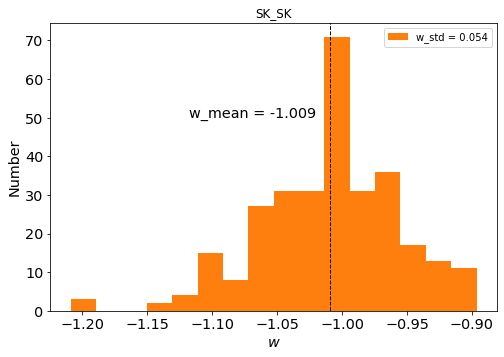

In [66]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

w_l = wfit_sk_sk.w
wmen = np.mean(w_l)
wstd = np.std(w_l)
ax.hist(w_l, bins='auto', color='C1', label=f'w_std = {wstd:.03f}')
ax.vline(wmen, lw=1, color='k', ls='--')
ax.text(-1.02, 50, s=f'w_mean = {wmen:.03f}', ha='right', fontsize='x-large')

ax.tick_params(labelsize='x-large')
    
ax.set_xlabel(r'$w$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend()

ax.set_title('SK_SK')

Text(0.5, 1.0, 'SK_SK')

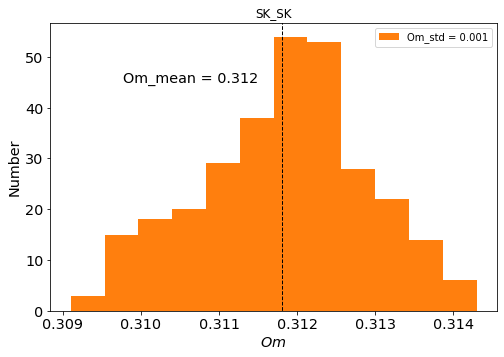

In [70]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

Om_l = wfit_sk_sk.omm
Ommen = np.mean(Om_l)
Omstd = np.std(Om_l)
ax.hist(Om_l, bins='auto', color='C1', label=f'Om_std = {Omstd:.03f}')
ax.vline(Ommen, lw=1, color='k', ls='--')
ax.text(0.3115, 45, s=f'Om_mean = {Ommen:.03f}', ha='right', fontsize='x-large')

ax.tick_params(labelsize='x-large')
    
ax.set_xlabel(r'$Om$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend()

ax.set_title('SK_SK')

### HR plots

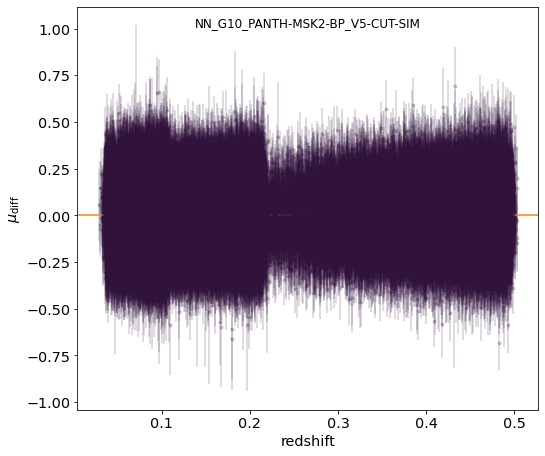

In [127]:
fig = plt.figure(figsize=[8,7])
ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])

checkit.show_hr(ax2=ax, show_leg=False)
ax.set_ylabel(r'$\mu_\mathrm{diff}$', fontsize='x-large')
fig.suptitle(checkit.name)

fig.savefig(f'../../../Images/pdf/{filename}_mudiff.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{filename}_mudiff.png', bbox_inches='tight', dpi=600)

### Development for binned residuals

In [153]:
nbins = 100
_, bins = np.histogram(checkit.sims_data.zCMB, bins=nbins)

slices = []
for i in range(nbins):
    slices.append(np.where((checkit.sims_data.zCMB > bins[i])
                           & (checkit.sims_data.zCMB <= bins[i+1]))[0])

#### Fit Gaussian stretch to each bin

In [170]:
def gauss(x, dx, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(dx**2+sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(x, mu, scale=sigma_eff)

GUESS = {'mu': 0., 'sigma': 0.25}

def minimize(nslice):
    '''Meilleure valeur des paramètres'''
    def loglikelihood(mu, sigma):
        '''La fonction à minimiser'''
        return -2*np.sum(np.log(gauss(checkit.sims_data.MURES.values[slices[nslice]],
                                      checkit.sims_data.MUERR.values[slices[nslice]],
                                      mu, sigma)))
    m_tot = im.Minuit(loglikelihood, **GUESS)
    migrad_out = m_tot.migrad()
    return m_tot

#### Computation of means and averages

In [192]:
z_comp_mean = np.zeros(nbins)
z_comp_std = np.zeros(nbins)
mu_comp_mean = np.zeros(nbins)
mu_comp_average = np.zeros(nbins)
mu_comp_std = np.zeros(nbins)

for i in range(nbins):
    if len(slices[i]) == 0:
        z_comp_mean[i] = -1
        z_comp_std[i] = -1
        mu_comp_mean[i] = -1
        mu_comp_average[i] = -1
        mu_comp_std[i] = -1
    else:
        z_comp_mean[i] = np.mean(checkit.sims_data.zCMB.values[slices[i]])
        z_comp_std[i] = np.std(checkit.sims_data.zCMB.values[slices[i]])
        mu_comp_mean[i] = np.mean(checkit.sims_data.MURES.values[slices[i]])
        mu_comp_average[i] = np.average(checkit.sims_data.MURES.values[slices[i]],
                                        weights=1/(checkit.sims_data.MUERR.values[slices[i]]**2 +
                                                   minimize(i).values[-1]**2))
        mu_comp_std[i] = np.std(checkit.sims_data.MURES.values[slices[i]])

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


#### Choose mean method

In [186]:
mean_c = ipw.Dropdown(options=['mean', 'weighted'],
                      value='mean',
                      description='Type of mean:')

display(mean_c)

Dropdown(description='Type of mean:', options=('mean', 'weighted'), value='mean')

#### Ok plot I guess

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


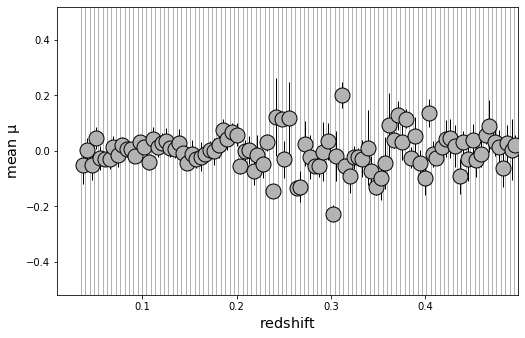

In [200]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

#############################################################################################

if mean_c.value == 'mean':
    for i in range(nbins):
        ax.errorbar(z_comp_mean[i], mu_comp_mean[i],
                    xerr=z_comp_std[i]/np.sqrt(len(checkit.sims_data.zCMB.values[slices[i]])),
                    yerr=mu_comp_std[i]/np.sqrt(len(checkit.sims_data.MUERR.values[slices[i]])),
                    **prop, zorder=10, lw=1)
else:
    for i in range(nbins):
        ax.errorbar(z_comp_mean[i], mu_comp_average[i],
                    xerr=z_comp_std[i]/np.sqrt(len(checkit.sims_data.zCMB.values[slices[i]])),
                    yerr=mu_comp_std[i]/np.sqrt(len(checkit.sims_data.MUERR.values[slices[i]])),
                    **prop, zorder=10, lw=1)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,\mu}$ ", fontsize="x-large")

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, np.max(checkit.sims_data.zCMB))
#ax.set_xscale('log')

#ax.legend(ncol=4, loc='upper center', columnspacing=1.4)

fig.savefig(f'../../../Images/pdf/{filename}_mudiff-binned_{mean_c.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{filename}_mudiff-binned_{mean_c.value}.png', bbox_inches='tight', dpi=600)

### Ssize plots and new NGEN calc

In [21]:
surveys_size = {survey:
                len(df_full[df_full['survey'] == survey])
                 for survey in surveys[1:-1]}
surveys_size

{'LOWZ': 172, 'SDSS': 335, 'PS1': 279, 'SNLS': 236}

#### For all

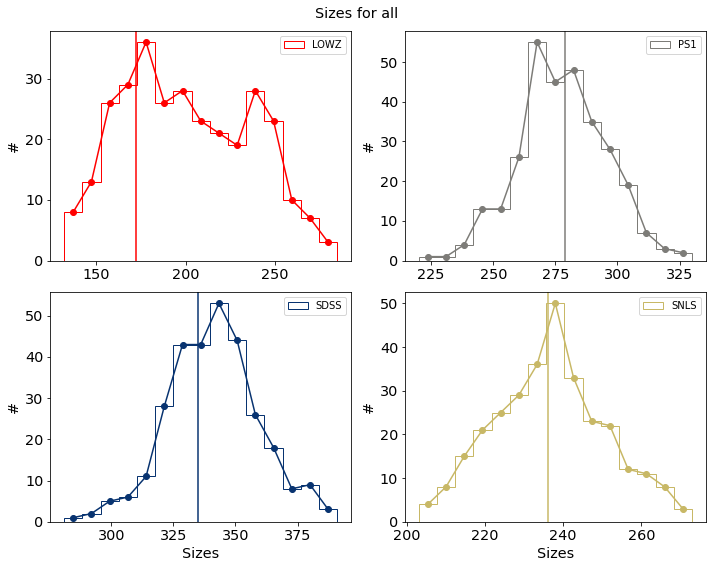

In [160]:
ssizes = pd.read_csv('../../../Data/sims/split_sizes-ALL.tsv', delimiter='\t')

fig, axs = plt.subplots(2, 2, figsize=[10,8])

i = -1

for a in range(2):
    for b in range(2):
        i += 1
        survey = ssizes.columns[i]
        hist = axs[a][b].hist(ssizes[survey],
                              histtype='step', bins=15,
                              color=colors[survey],
                              label=survey)
        xlim = axs[a][b].get_xlim()
        ylim = axs[a][b].get_ylim()
        axs[a][b].vline(surveys_size[survey], color=colors[survey])
        axs[a][b].plot(
            (hist[1][:-1]+hist[1][1:])/2,
            hist[0], marker='o',
            color=colors[survey])
        axs[a][b].set_xlim(xlim)
        axs[a][b].set_ylim(ylim)
        axs[a][b].tick_params(labelsize='x-large')
        if i < 2:
            pass
        else:
            axs[a][b].set_xlabel('Sizes', fontsize='x-large')
        axs[a][b].set_ylabel('#', fontsize='x-large')
        axs[a][b].legend()
        # axs[a][b].set_title(survey)
    
fig.suptitle('Sizes for all', fontsize='x-large')

fig.tight_layout()

fig.savefig(f'../../../Images/pdf/ssizes_all.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/ssizes_all.png', bbox_inches='tight', dpi=600)

#### Per survey

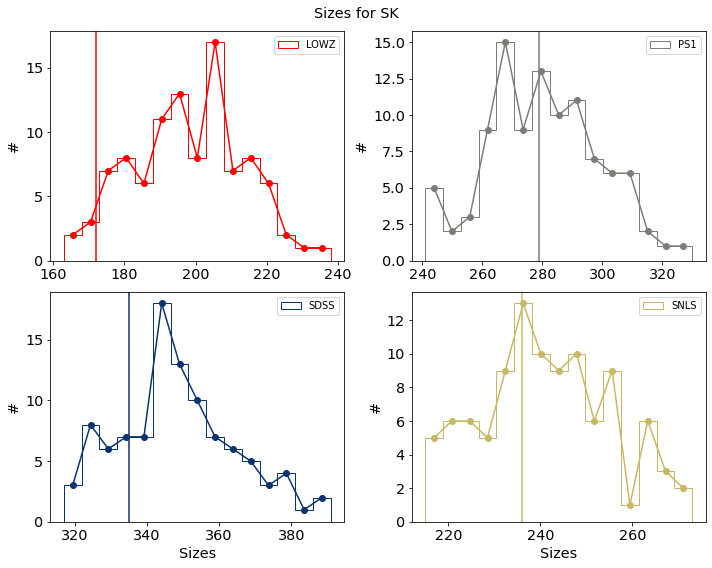

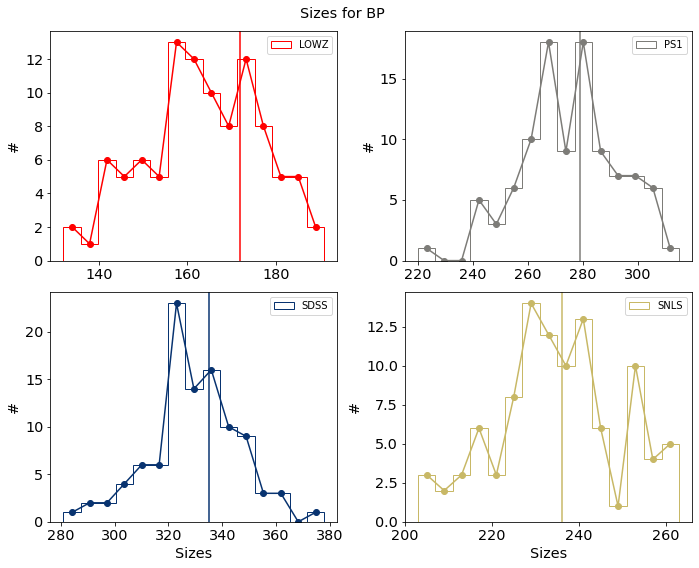

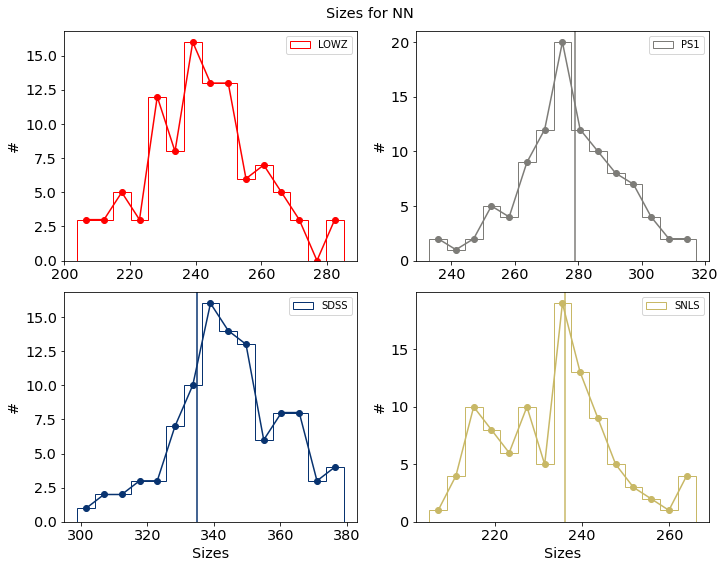

In [163]:
ssizez = dict()
for s in order:
    ssizez[s] = pd.read_csv(f'../../../Data/sims/split_sizes-{s}.tsv',
                            delimiter='\t')

    fig, axs = plt.subplots(2, 2, figsize=[10,8])
    
    i = -1
    
    for a in range(2):
        for b in range(2):
            i += 1
            survey = ssizez[s].columns[i]
            hist = axs[a][b].hist(ssizez[s][survey],
                                  histtype='step', bins=15,
                                  color=colors[survey],
                                  label=survey)
            xlim = axs[a][b].get_xlim()
            ylim = axs[a][b].get_ylim()
            axs[a][b].vline(surveys_size[survey], color=colors[survey])
            axs[a][b].plot(
                (hist[1][:-1]+hist[1][1:])/2,
                hist[0], marker='o',
                color=colors[survey])
            axs[a][b].set_xlim(xlim)
            axs[a][b].set_ylim(ylim)
            axs[a][b].tick_params(labelsize='x-large')
            if i < 2:
                pass
            else:
                axs[a][b].set_xlabel('Sizes', fontsize='x-large')
            axs[a][b].set_ylabel('#', fontsize='x-large')
            axs[a][b].legend()
            # axs[a][b].set_title(survey)
        
    fig.suptitle(f'Sizes for {s}', fontsize='x-large')
    
    fig.tight_layout()
    
    fig.savefig(f'../../../Images/pdf/ssizes_{s}.pdf', bbox_inches='tight')
    fig.savefig(f'../../../Images/png/ssizes_{s}.png', bbox_inches='tight', dpi=600)

### Compute NGEN ssize

In [73]:
ssizez = dict()
ssizem = dict()
for s in order:
    ssizez[s] = pd.read_csv(f'../../../Data/sims/split_sizes-{s}.tsv',
                            delimiter='\t')
    ssizem[s] = np.mean(ssizez[s])

NGENs = {'SK': {'LOWZ': 1.49,
                'SDSS': 0.95,
                'SNLS': 0.30,
                'PS1': 0.44},
         'BP':{'LOWZ': 1.49,
                'SDSS': 0.95,
                'SNLS': 0.30,
                'PS1': 0.44},
         'NN':{'LOWZ': 1.49,
                'SDSS': 0.95,
                'SNLS': 0.30,
                'PS1': 0.44}}
NGENss = {'SK': {},
          'BP': {},
          'NN': {}}

for o in order:
    for s in surveys[1:-1]:
        NGENss[o][s] = surveys_size[s]*NGENs[o][s]/ssizem[o][s]

In [74]:
NGENss

{'SK': {'LOWZ': 1.2986065366100834,
  'SDSS': 0.9130422308928161,
  'PS1': 0.43799058084772374,
  'SNLS': 0.2933742178759375},
 'BP': {'LOWZ': 1.5661207528721584,
  'SDSS': 0.9658573596358119,
  'PS1': 0.4462215113954418,
  'SNLS': 0.30166169578184915},
 'NN': {'LOWZ': 1.0584833966628118,
  'SDSS': 0.9252260371544029,
  'PS1': 0.4432248980033938,
  'SNLS': 0.30331591123297064}}

### Compute SSIZE NGEN first try

In [64]:
ssizesm = {'LOWZ': 2314.51,
        'SDSS': 4132.39,
        'PS1': 4396.65,
        'SNLS': 4082.94}

In [65]:
NGEN = {'LOWZ': 20,
        'SDSS': 11.68,
        'PS1': 6.95,
        'SNLS': 5.16}

In [66]:
NGEN_g = {}
for s in surveys[1:-1]:
    NGEN_g[s] = surveys_size[s]*NGEN[s]/ssizesm[s]

### Old dev for figure

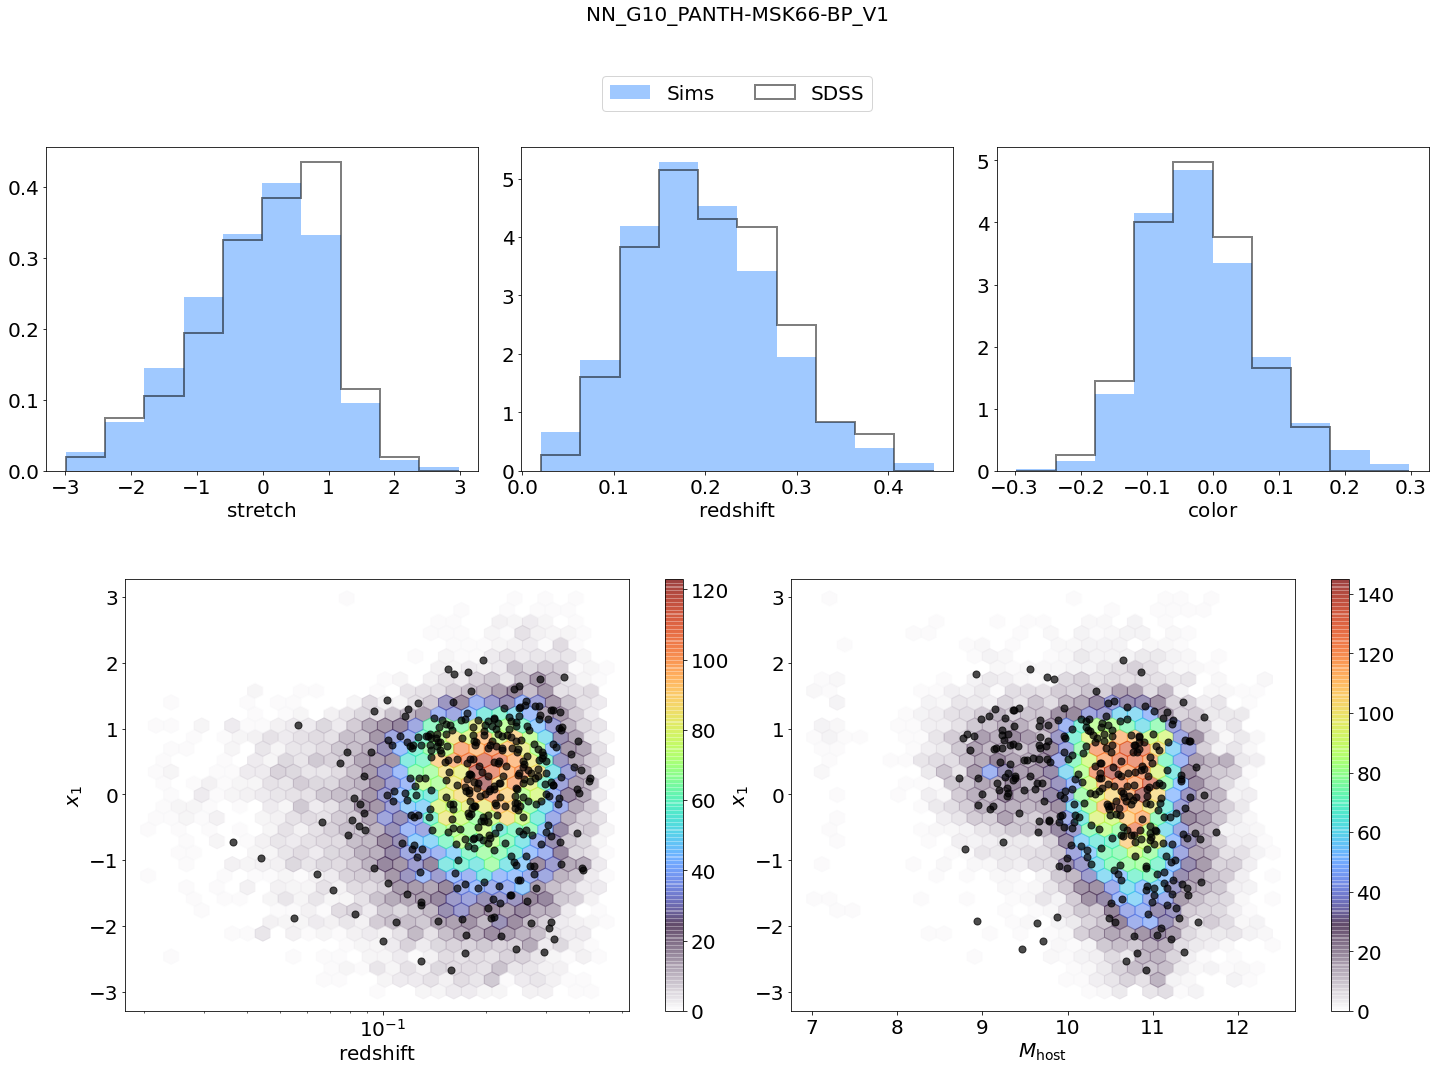

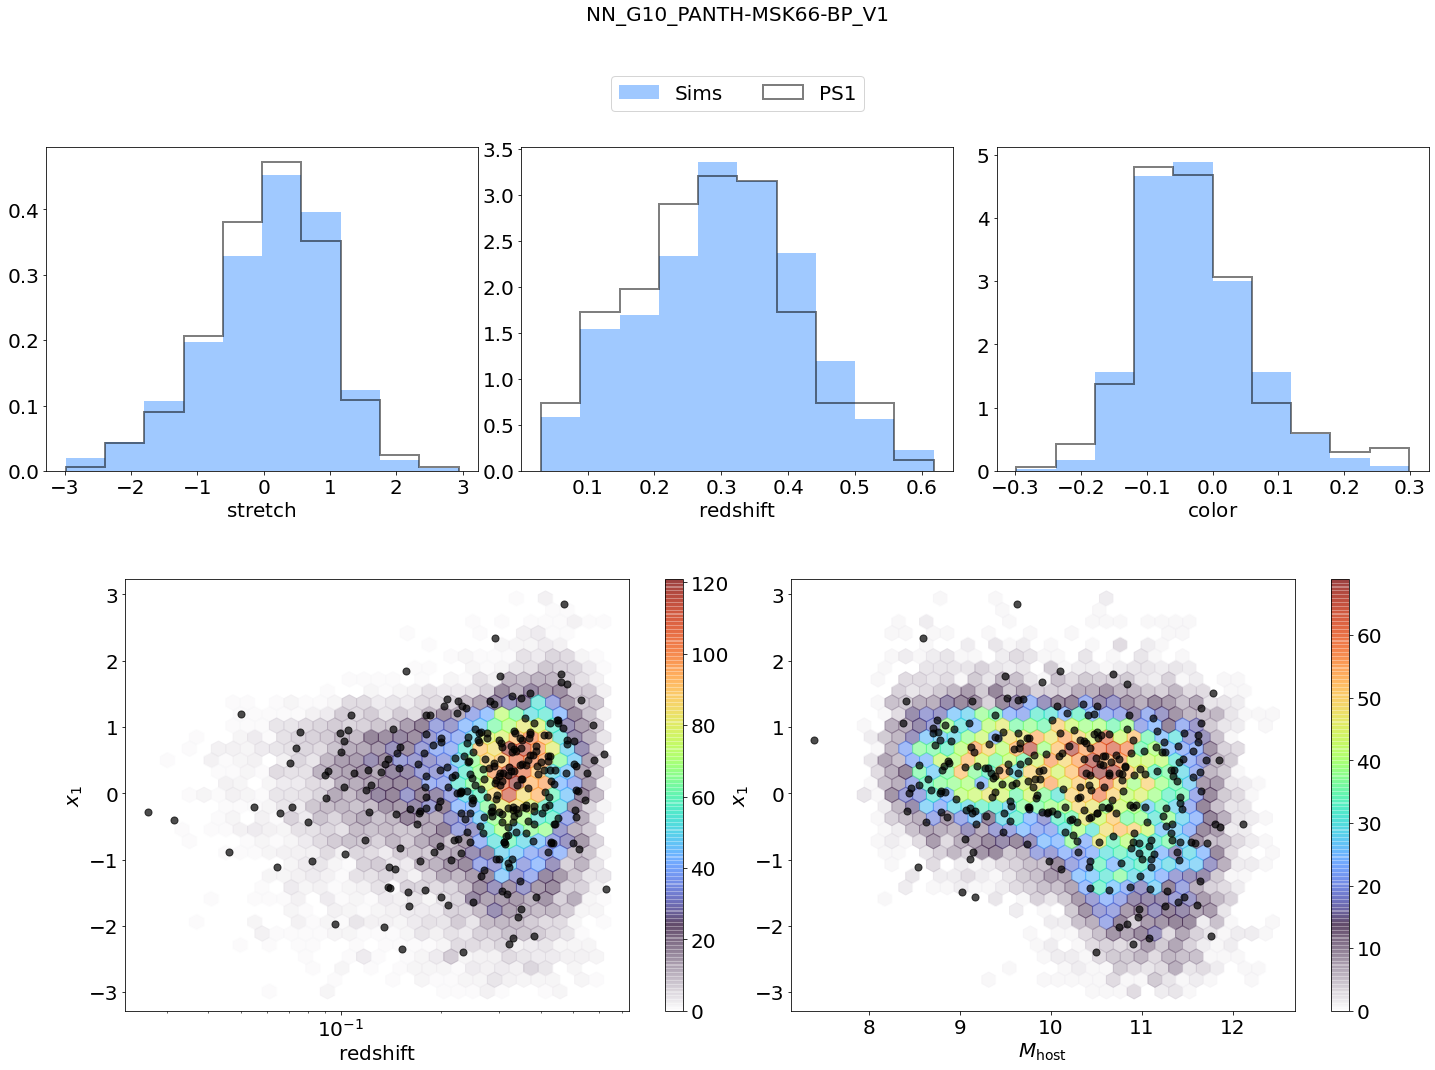

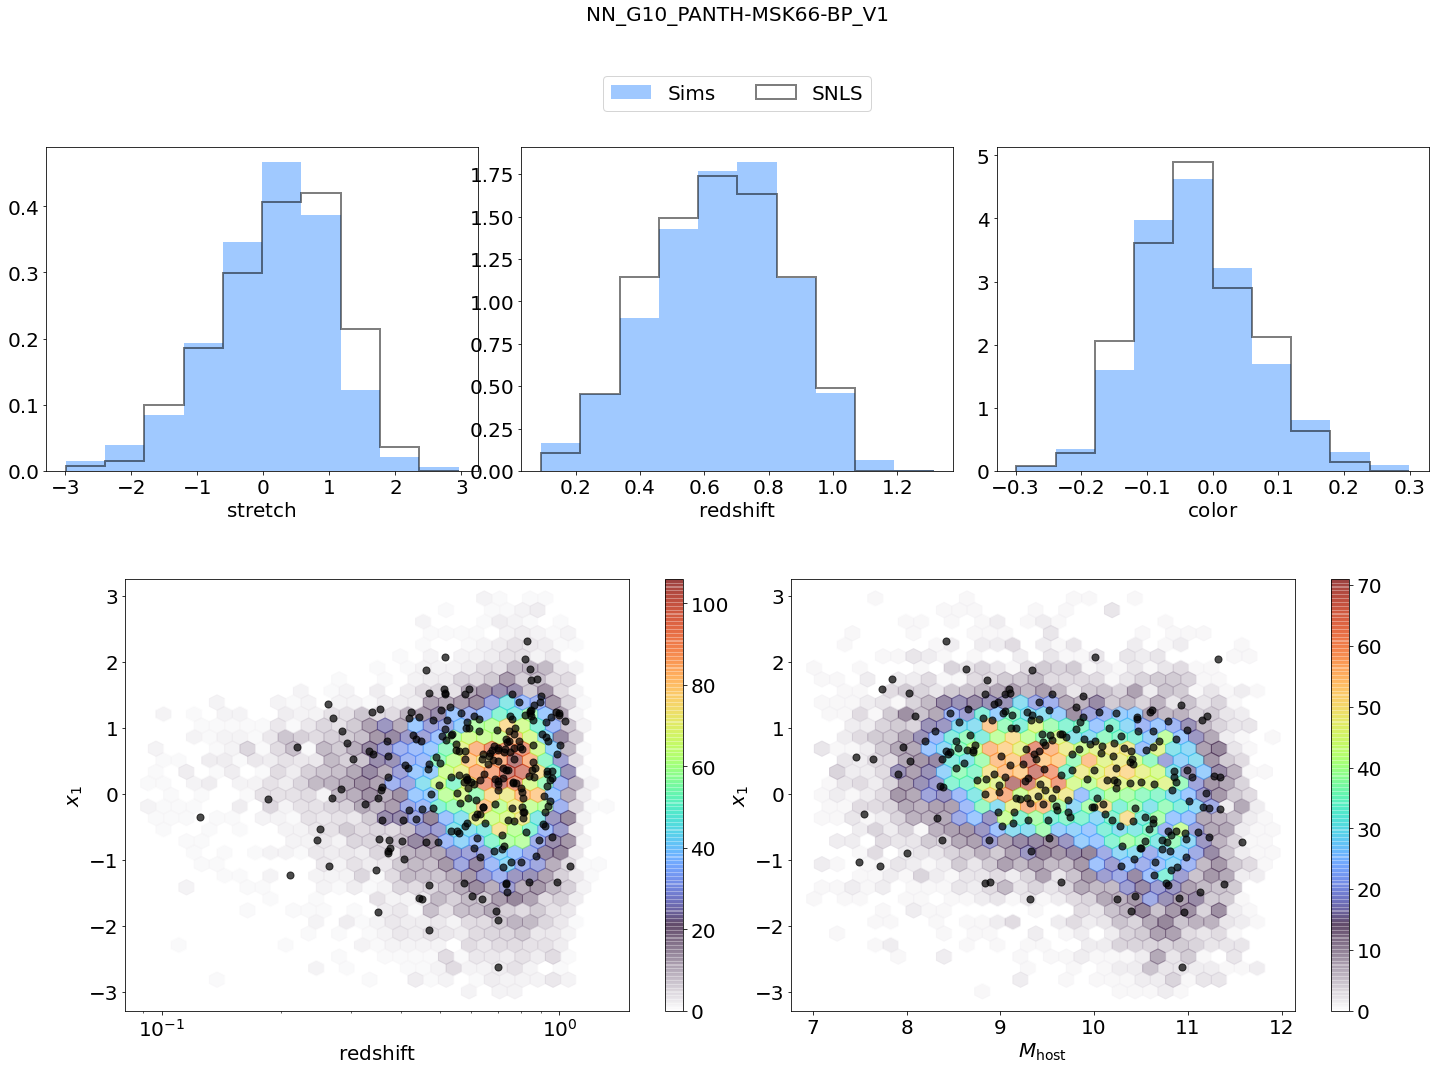

In [7]:
width_plot_cb = 0.35
space_cb = 0.025
width_cb = 0.0125
xmin_bottom = 0.075
ymin_bottom = 0.05
height_plot_cb = 0.40

xmin_top = 0.02
ymin_top = 0.15 + height_plot_cb
width_plot = 0.30
space_plot = 0.03
height_plot = 0.30

for i, zipped in enumerate(zip(surveys[1:-1], [1, 15, 4])):
    survey = zipped[0]
    idsurvey = zipped[-1]
    fig = plt.figure(figsize=[20, 15])
    
    ax4 = fig.add_axes([xmin_top, ymin_top,
                        width_plot, height_plot])
    
    ax1 = fig.add_axes([ax4.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax5 = fig.add_axes([ax1.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax2 = fig.add_axes([xmin_bottom, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axb = fig.add_axes([ax2.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    ax3 = fig.add_axes([axb.get_position().get_points()[1][0]
                        + 3*space_cb, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axc = fig.add_axes([ax3.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    df_full_data_used = df_full[df_full['survey'] == survey]
    fitprop_data_used = fitprop_data[fitprop_data['IDSURVEY'] == idsurvey]
    
    color_data = 'k'
    
    #############################################################################
    
    prophist = dict(alpha=.5, density=True)
    
    _, bins, _ = ax1.hist(fitprop_data_used.zCMB,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax1.hist(df_full_data_used.redshifts,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    _, bins, _ = ax4.hist(fitprop_data_used.x1,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax4.hist(df_full_data_used.stretchs,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    
    _, bins, _ = ax5.hist(fitprop_data_used.c,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax5.hist(df_full_data_used.colors,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    #############################################################################
    
    prop2d = dict(alpha=.5, gridsize=30, cmap=tools.cmap_tpw)
    
    
    hb2 = ax2.hexbin(fitprop_data_used.zCMB,
                     fitprop_data_used.x1,
                     xscale='log',
                     **prop2d)
    ax2.set_xscale('log')
    
    cb2 = fig.colorbar(hb2, cax=axb)
    
    prop = dict(marker="o", s=50, lw=1, alpha=.7, color=color_data)
    
    ax2.scatter(df_full_data_used.redshifts,
                df_full_data_used.stretchs,
                label=survey, **prop)
    
    #############################################################################
    
    fitprop_data_used_mass7 = fitprop_data_used[fitprop_data_used['HOST_LOGMASS'] > 7]
    df_full_data_used_mass7 = df_full_data_used[df_full_data_used['hostmass'] > 7]
    
    hb3 = ax3.hexbin(fitprop_data_used_mass7.HOST_LOGMASS,
                     fitprop_data_used_mass7.x1,
                     **prop2d)
    
    cb3 = fig.colorbar(hb3, cax=axc)
    
    ax3.scatter(df_full_data_used_mass7.hostmass,
                df_full_data_used_mass7.stretchs,
                label=survey, **prop)
    #############################################################################
    
    ax1.tick_params(labelsize=20)
    ax4.tick_params(labelsize=20)
    ax5.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    cb2.ax.tick_params(labelsize=20)
    ax3.tick_params(labelsize=20)
    cb3.ax.tick_params(labelsize=20)
    
    ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    #ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax4.set_xlabel(r"$\mathrm{stretch}$ ", fontsize=20)
    #ax4.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax5.set_xlabel(r"$\mathrm{color}$ ", fontsize=20)
    #ax5.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    ax2.set_ylabel(r"$x_1$", fontsize=20)
    #cb2.set_label('counts', fontsize=20)
    
    ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
    ax3.set_ylabel(r"$x_1$", fontsize=20)
    #cb3.set_label('counts', fontsize=20)
    
    ax1.legend(fontsize=20, ncol=2,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.0, 0.0, 0.25))
    
    fig.suptitle(sc.value.split('/')[-1], fontsize=20)
    
    #fig.savefig('../../../Images/pdf/fitprop_data_' + sc.value.split('/')[-1]
    #            + '_' + survey + '.pdf',
    #            bbox_inches='tight')
    #fig.savefig('../../../Images/png/fitprop_data_' + sc.value.split('/')[-1]
    #            + '_' + survey + '.png',
    #            bbox_inches='tight', transparent=False)

## `age` module testing

In [3]:
pdmodel = age.PrompDelayModel()
pdmodel.draw_sample(z=0.04, size=1000)

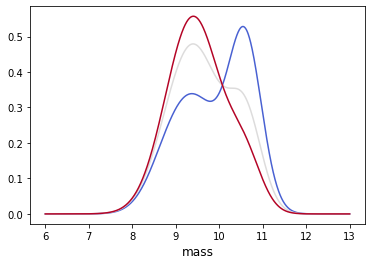

In [4]:
fig = pdmodel.show_pdf("mass", z=[0.05, 0.5, 1], zmax=1)

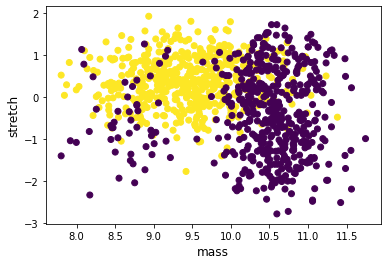

In [5]:
fig = pdmodel.show_scatter("mass","stretch", colorkey="age")

## Fit mass Brodie

In [6]:
with open('../../../Data/sne/lowz_df', 'rb') as f:
    lowz_df = pickle.load(f)

In [50]:
lowz_df['hg_masserr_nr'] = np.sqrt((lowz_df['hg_masserr_nr_down']**2
                                    + lowz_df['hg_masserr_nr_up']**2)/2)

In [51]:
lowz_df_fit = lowz_df.copy()
lowz_df_fit

In [46]:
lowz_df_fit.rename(columns={'zcmb': 'redshifts',
                            'hg_mass_nr': 'hostmass';
                            'hg_masserr_nr': 'hostmass_err'})

,CID,ra,dec,zcmb,hg_mass_sco,hg_masserr_sco,hg_mass_nr,hg_masserr_nr_down,hg_masserr_nr_up
0,2001ah,167.624,55.1608,0.05891,11.141,0.02,11.733746,0.100610,0.102540
1,2001az,248.614,76.0295,0.04059,11.376,0.059,11.563016,0.098809,0.099862
2,2001da,358.386,8.11728,0.01647,11.006,0.042,11.246402,0.100754,0.099997
3,2001en,21.3452,34.025,0.01544,11.133,0.078,11.390831,0.098434,0.100087
4,2001fe,144.488,25.4947,0.01449,10.277,0.095,11.013707,0.100463,0.099176
...,...,...,...,...,...,...,...,...,...
165,2000B,106.417,50.5888,0.02045,11.44,2.78,12.175438,0.098304,0.098759
166,2000cf,238.248,65.9378,0.03646,10.1732,0.2809,10.743448,0.098631,0.099377
167,2000cn,269.425,27.8257,0.02321,10.9619,0.2809,11.172982,0.100555,0.099259
168,2000dk,16.8446,32.4111,0.01602,10.4766,0.3742,12.195576,0.099497,0.099416


In [64]:
base_model = massevol.Evol3G3M3S(df)
base_model.minimize(limit_a=(0,1))
print(base_model.param)

{'mu_1': 9.42435033203514, 'sigma_1': 0.6352164641545026, 'a': 0.902710356796472, 'mu_2': 10.59321817727873, 'sigma_2': 0.3739487056160915, 'mu_3': 8.74496390066, 'sigma_3': 0.42788950723936164}


In [63]:
with open('../../../Data/mass/snf_mass', 'rb') as f:
    snf_mass = pickle.load(f)

### Plot mass histograms

#### Sco vs Taylor

No handles with labels found to put in legend.
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


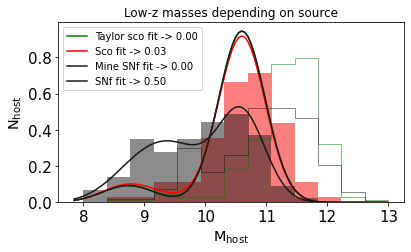

In [67]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=13, range=[8, 13], alpha=.5, density=True)

lowz_df_nr_sup8 = lowz_df[lowz_df['hg_mass_nr'] > 8]
ax.hist(lowz_df_nr_sup8['hg_mass_nr'],
        histtype='step',
        color='g',
        **prop_hist)

lowz_df_sco_sup8 = lowz_df[lowz_df['hg_mass_sco'] > 8]
ax.hist(lowz_df_sco_sup8['hg_mass_sco'],
        color=colors['low-z'],
        **prop_hist)

ax.hist(snf_mass[:, 0],
        color=colors['SNF'],
        **prop_hist,
        histtype='step')

ax.hist(df['hostmass'],
        color=colors['SNF'],
        **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper left')

plt.title('Low-z masses depending on source')

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass_nr(fprompt):
    return -2*np.sum(np.log(pdf_mass(lowz_df_nr_sup8['hg_mass_nr'], fprompt)))

hg_sco_nparray = [lowz_df_sco_sup8['hg_mass_sco'].values[i]
                  for i in range(len(lowz_df_sco_sup8))]
def loglikepdf_mass_sco(fprompt):
    return -2*np.sum(np.log(pdf_mass(hg_sco_nparray, fprompt)))

def loglikepdf_mass_snf_mine(fprompt):
    return -2*np.sum(np.log(pdf_mass(snf_mass[:, 0], fprompt)))

def loglikepdf_mass_snf(fprompt):
    return -2*np.sum(np.log(pdf_mass(df['hostmass'], fprompt)))

def minimize_pdf_mass_nr(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_nr,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_sco(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_sco,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf_mine(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf_mine,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass_nr = minimize_pdf_mass_nr().values['fprompt']
bestfit_mass_sco = minimize_pdf_mass_sco().values['fprompt']
bestfit_mass_snf_mine = minimize_pdf_mass_snf_mine().values['fprompt']
bestfit_mass_snf = minimize_pdf_mass_snf().values['fprompt']

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_nr),
        color='g',
        label=f'Taylor sco fit -> {bestfit_mass_nr:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_sco),
        color=colors['low-z'],
        label=f'Sco fit -> {bestfit_mass_sco:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf_mine),
        color=colors['SNF'],
        label=f'Mine SNf fit -> {bestfit_mass_snf_mine:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf),
        color=colors['SNF'],
        label=f'SNf fit -> {bestfit_mass_snf:.2f}')

ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
fig.savefig('../../../Images/pdf/mass_hists-fitted.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mass_hists-fitted.png', bbox_inches='tight', dpi=600)

### Use SED fitted SNf data

In [30]:
sedsnf = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sedsnf = sedsnf.loc[sedsnf['name'].str.contains( 'SNF|LSQ|PTF', na=False, regex=True)]
sedsnf = sedsnf.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sedsnf['hostmass_err'] = np.sqrt((sedsnf['mass_uppererr'].values**2 +
                                  sedsnf['mass_lowerr'].values**2)/2)
sedsnf_df = df_nc[df_nc['survey'] == 'SNF']
sedsnf_df['hostmass'] = sedsnf['hostmass'].values
sedsnf_df['hostmass_err'] = sedsnf['hostmass_err'].values
sedsnf_df_nonan = sedsnf_df[~np.isnan(sedsnf_df['hostmass'])]

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### lowz vs SNF_sed

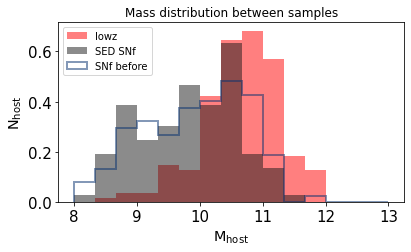

In [37]:
fig = plt.figure(figsize=[8, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=15, range=[8, 13], alpha=.5, density=True)

# Actual lowz df
lowz_df = df_nc[df_nc['survey'] == 'low-z']
lowz_df_sco_sup8 = lowz_df[lowz_df['hostmass'] > 8]
ax.hist(lowz_df['hostmass'],
        color=colors['low-z'],
        label='lowz',
        **prop_hist)

# SED-fitted SNf masses
ax.hist(sedsnf_df_nonan['hostmass'],
        color=colors['SNF'],
        label='SED SNf',
        **prop_hist)

# # SED-fitted SNf masses + shift
# shift = 0.5
# ax.hist(sedsnf_df_nonan['hostmass']+shift,
#         color=colors['SNF'],
#         label=f'SED SNf+{shift}',
#         histtype='step',
#         lw=2,
#         **prop_hist)

# Previous SNf masses
ax.hist(df_nc[df_nc['survey'] == 'SNF']['hostmass'],
        color=colors['SDSS'],
        label='SNf before',
        histtype='step',
        lw=2,
        **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper left')

plt.title('Mass distribution between samples')

fig.savefig('../../../Images/pdf/lowz_sedsnfnonan_comp-hist.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_sedsnfnonan_comp-hist.png',
            bbox_inches='tight', dpi=600)

#### Samples vs SNF_sed

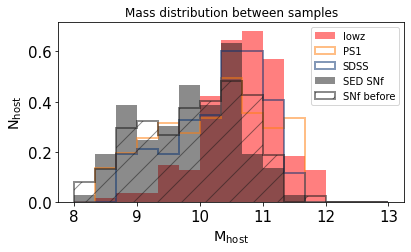

In [55]:
fig = plt.figure(figsize=[8, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=15, range=[8, 13], alpha=.5, density=True)

# Actual lowz df
ax.hist(df_nc[df_nc['survey'] == 'low-z']['hostmass'],
        color=colors['low-z'],
        label='lowz',# hatch='/',
        **prop_hist)

# Actual PS1 df
ax.hist(df_nc[df_nc['survey'] == 'PS1']['hostmass'],
        color='C1',
        label='PS1',# hatch='-',
        histtype='step', lw=2,
        **prop_hist)

# Actual SDSS df
ax.hist(df_nc[df_nc['survey'] == 'SDSS']['hostmass'],
        color=colors['SDSS'],
        label='SDSS',# hatch='\\',
        histtype='step', lw=2,
        **prop_hist)

# SED-fitted SNf masses
ax.hist(sedsnf_df_nonan['hostmass'],
        color=colors['SNF'],
        label='SED SNf',# hatch='|',
        **prop_hist)

# Previous SNf masses
ax.hist(df_nc[df_nc['survey'] == 'SNF']['hostmass'],
        color=colors['SNF'],
        label='SNf before', hatch='/',
        histtype='step', lw=2,
        **prop_hist)

# # SED-fitted SNf masses + shift
# shift = 0.5
# ax.hist(sedsnf_df_nonan['hostmass']+shift,
#         color=colors['SNF'],
#         label=f'SED SNf+{shift}',
#         histtype='step',
#         lw=2,
#         **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper right')

plt.title('Mass distribution between samples')

fig.savefig('../../../Images/pdf/samples_sedsnfnonan_comp-hist.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/samples_sedsnfnonan_comp-hist.png',
            bbox_inches='tight', dpi=600)

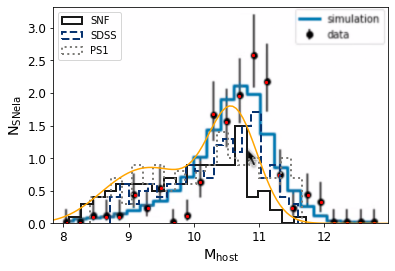

In [70]:
img = plt.imread("../../../Images/png/mass_hist_lowz_crop_zero.png")
fig, ax = plt.subplots()

Mmin = 7.85
Mmax = 12.98
Cmin = 0
Cmax = 170
f = 85.185

Mlist = [8.05, 8.25, 8.45, 8.65, 8.85,
         9.1, 9.3, 9.5, 9.7, 9.9,
         10.1, 10.3, 10.5, 10.7, 10.9,
         11.1, 11.3, 11.5, 11.75, 11.95,
         12.15, 12.35, 12.55, 12.76]

ax.scatter(Mlist,
           np.asarray([0, 0, 8, 8, 8,
                       37, 20, 46, 0, 10,
                       54, 143, 132, 166, 220,
                       185, 63, 20, 37, 28,
                       1, 0, 0, 0])/f,
          color='red', s=5)
ax.imshow(img, extent=[Mmin, Mmax, 0, 3.32])
          #[7.81, 12.94, 0, 170])

#ax.set_xlim([7.81, 12.94])
#ax.set_ylim([0, 170])

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass(fprompt):
    return -2*np.sum(np.log(pdf_mass(Mlist, fprompt)))

def minimize_pdf_mass(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass,
                      print_level=print_level,
                      pedantic=False,
                      fprompt=0.1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass = minimize_pdf_mass().values

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        3*pdf_mass(xlin, bestfit_mass['fprompt']),
        color='orange')

ls = ['-', '--', ':']

for i, survey in enumerate(surveys[:3]):
    df_ncused = df_nc[df_nc['survey'] == survey]
    where = df_ncused['hostmass'] > 8
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused[where].hostmass, bins=20,
            weights=[0.100 for i in range(len(df_ncused[where].hostmass))],
            histtype='step', lw=2, fill=False,
            zorder=1,
            edgecolor=colors[survey],
            facecolor=alphacolors(.5, survey),
            ls=ls[i], label=survey)
    
ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
#fig.savefig('../../../Images/png/mass_hist_lowz-fitted.png', bbox_inches='tight', dpi=600)

In [112]:
bestfit_mass['fprompt']

0.41157248447333517